In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your dataset folders
data_dir = '/content/drive/MyDrive/dl/lung_colon_image_set'
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/labels120.npy",tr_labels)


KeyboardInterrupt: 

In [ ]:
np.save("/content/drive/MyDrive/Deep_Learning_Assignment/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/Deep_Learning_Assignment/labels120.npy",tr_labels)

Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

#Call data from directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pickle
import random
from numpy.random import seed
seed(42)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from keras.models import Model
from tensorflow.keras.saving import load_model
from tensorflow.keras import Sequential,models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,AveragePooling2D,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,auc, roc_curve, roc_auc_score
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from itertools import cycle
from sklearn.metrics._plot.roc_curve import RocCurveDisplay
from keras.applications.vgg16 import VGG16
import logging
logging.getLogger('tensorflow').disabled = True
file_dir = "/content/drive/MyDrive/Deep_Learning_Assignment/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)


Mounted at /content/drive
['Lung adenocarcinoma' 'Lung adenocarcinoma' 'Lung adenocarcinoma' ...
 'Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [ ]:
#This cell was inspired by the provided guide to ROC
# Convert string labels to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# Convert labels to categorical
one_hot_labels = to_categorical(integer_encoded)
#Checking if it worked by calling an example of each class before and after
print([labels[0]],[labels[5500]],[labels[10500]],[labels[15500]],[labels[20500]])
print(one_hot_labels[0],one_hot_labels[5500],one_hot_labels[10500],one_hot_labels[15500],one_hot_labels[20500])
print(one_hot_labels.shape, one_hot_labels.dtype)


['Lung adenocarcinoma'] ['Lung Benign Tissue'] ['Lung Squamous Cell Carcinoma'] ['Colon Benign Tissue'] ['Colon adenocarcinoma']
[0. 0. 0. 0. 1.] [0. 0. 1. 0. 0.] [0. 0. 0. 1. 0.] [1. 0. 0. 0. 0.] [0. 1. 0. 0. 0.]
(25000, 5) float32


## Visualizing Sample Images

[23654, 15795, 860, 5390, 21575, 11964, 11284, 22118, 6265, 16850, 4426, 21962, 14423, 11363, 16023]


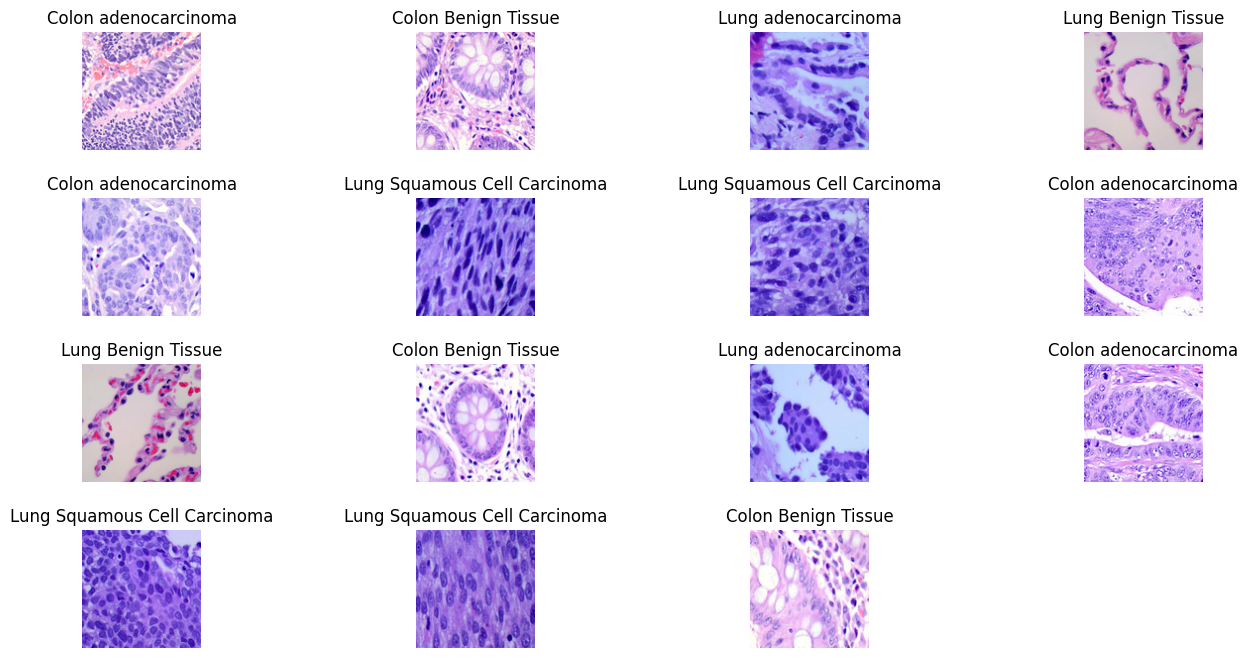

In [ ]:
#Creating an empty list to add random numbers between 0 and 25021
random_list=[]
#Create u to use it as counter for subplot creation
u=0
#add random numbers between 0 and 25021
for i in range(15):
  random_list.append(np.random.randint(0,25021))
print(random_list)
#Create a figure with subplots
plt.figure(figsize=(16,8))
#Loop through the random_list and use the numbers as index for labels and pictures
for i in random_list:
    u+=1
    plt.subplot(4,4,u)
    plt.imshow(data[i])
    plt.title(labels[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

## Visualizing Class Distribution

Colon Benign Tissue 5000
Colon adenocarcinoma 5000
Lung Benign Tissue 5000
Lung Squamous Cell Carcinoma 5000
Lung adenocarcinoma 5000


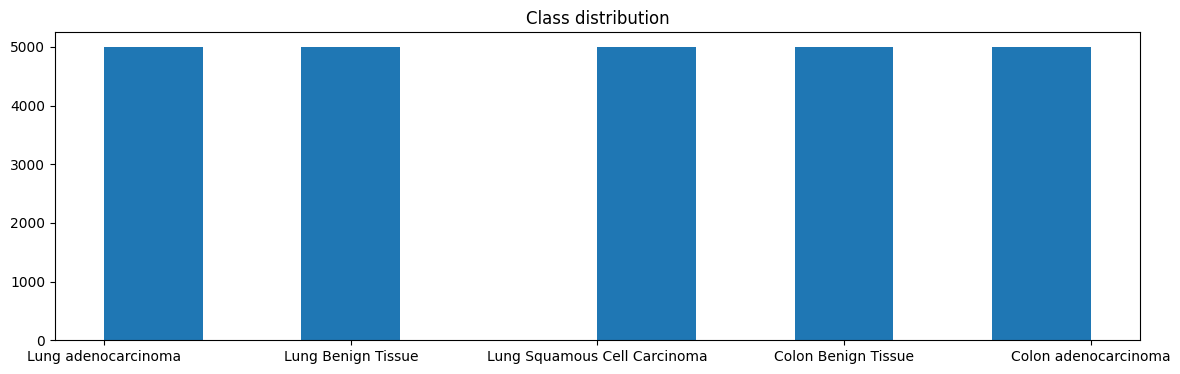

In [ ]:
#Creating histogramm to visualize the class distribution
plt.figure(figsize=(14,4))
plt.hist(labels)
plt.title("Class distribution")
#Count how often each label occurs
for i in np.unique(labels):
  print(i,np.count_nonzero(labels==i))


##Train-Test-Val Split

In [ ]:
#Normalizing uses too much ram but could improve performance
#Data gets split into training data and combined data (60:40)
X_trainval, X_test, y_trainval, y_test = train_test_split(data, one_hot_labels, test_size = 0.2, stratify=one_hot_labels, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, stratify=y_trainval, random_state = 42)
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 120, 120, 3) (5000, 120, 120, 3) (5000, 120, 120, 3)


# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [ ]:
## LOSS-ACC GRAPHS

#modified plot_history function from the practicals to only give int values for the x-axis
def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.xticks(range(1, len(data_list[0]) + 1))  # Set x-axis ticks to integer values
    plt.legend()
    plt.show()


In [ ]:
#Conf matrix and Classification Report:
def cm_cl(model, X_test, y_test,title="Test data CM"):
  #creating model predictions for X_test and matching them with true labels
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_test_classes = y_test.argmax(axis=1)
  #creating confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
  #calculating accuracy score
    acc = accuracy_score(y_test_classes, y_pred_classes)
    print('test_accuracy: %.3f' % acc)
  #creating classification report
    cls = classification_report(y_test_classes, y_pred_classes)

    return print(title),print(cm),print(cls),print("-------------------------------------------------------------------")


In [ ]:
#ROC one vs rest curves
#This cell was partially inspired by the provided guide to ROC
def ROC_curves(model, X, y, fig_name):
    #creating the fpr, tpr, and roc_auc dictionaries
    fpr, tpr, roc_auc = dict(), dict(), dict()
    #Evaluate the model on validation sets
    pred_probs = model.predict(X)
    #Calculating micro average
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #plotting
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    #plotting the normal curves
    for i in range(5):
        RocCurveDisplay.from_predictions(
            y[:, i],
            pred_probs[:, i],
            name=f"ROC curve for class {i}",
            ax=ax1
        )
    #plotting micro-average
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
  #calculating macro average
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    #Interpolate the ROC curves
    mean_tpr = np.zeros_like(fpr_grid)
    for i in range(5):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    #Average it and compute AUC
    mean_tpr /= 5
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #plotting macro average
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0} Set: ROC Curve of model'.format(fig_name))
    plt.legend()
    plt.show()
    return

# Baseline Model

In [ ]:
#initialize model
base=Sequential()
kernel=(3,3)
#add layers to model
base.add(Conv2D(128,input_shape=(120,120,3),kernel_size=kernel,activation='relu',padding='same'))
base.add(MaxPooling2D(pool_size=(2,2)))
base.add(Conv2D(64,kernel_size=kernel,activation='relu',padding='same'))
base.add(MaxPooling2D(pool_size=(2,2)))
base.add(Flatten())
base.add(Dense(128,activation='relu'))
base.add(Dense(32,activation='relu'))
base.add(Dense(5,activation='softmax'))
base.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [ ]:
base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = base.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=10, batch_size=32)

Epoch 1/10
469/469 [==============================] - 17s 34ms/step - loss: 0.4807 - accuracy: 0.7747 - val_loss: 0.7461 - val_accuracy: 0.6698
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.4573 - accuracy: 0.7839 - val_loss: 0.7906 - val_accuracy: 0.7378
Epoch 3/10
469/469 [==============================] - 19s 40ms/step - loss: 0.4099 - accuracy: 0.8103 - val_loss: 0.7634 - val_accuracy: 0.7346
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 0.3709 - accuracy: 0.8230 - val_loss: 0.7835 - val_accuracy: 0.7440
Epoch 5/10
469/469 [==============================] - 15s 33ms/step - loss: 0.4026 - accuracy: 0.8120 - val_loss: 0.8767 - val_accuracy: 0.7354
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.3465 - accuracy: 0.8391 - val_loss: 0.8016 - val_accuracy: 0.7376
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.3259 - accuracy: 0.8502 - val_loss: 0.8400 - val_accuracy:

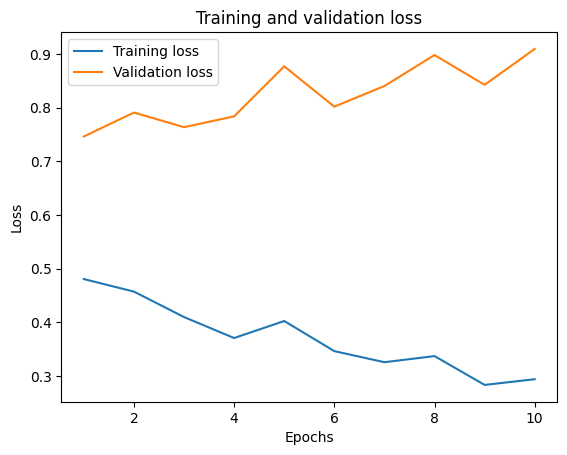

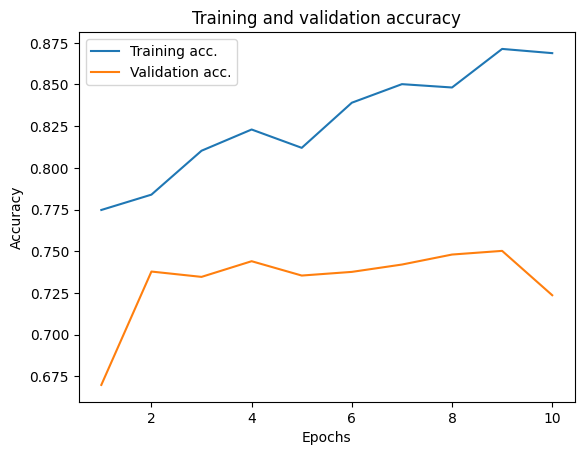

157/157 [==============================] - 1s 7ms/step
test_accuracy: 0.724
Validation data CM
[[663 331   4   0   2]
 [255 733   3   1   8]
 [ 65  30 882   2  21]
 [  0   8   1 676 315]
 [  6  66  36 228 664]]
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      1000
           1       0.63      0.73      0.68      1000
           2       0.95      0.88      0.92      1000
           3       0.75      0.68      0.71      1000
           4       0.66      0.66      0.66      1000

    accuracy                           0.72      5000
   macro avg       0.73      0.72      0.73      5000
weighted avg       0.73      0.72      0.73      5000

-------------------------------------------------------------------
157/157 [==============================] - 1s 7ms/step
test_accuracy: 0.741
Test data CM
[[672 326   2   0   0]
 [227 755   5   1  12]
 [ 72  29 881   2  16]
 [  0   8   1 712 279]
 [  3  63  33 217 684]]
              precision    

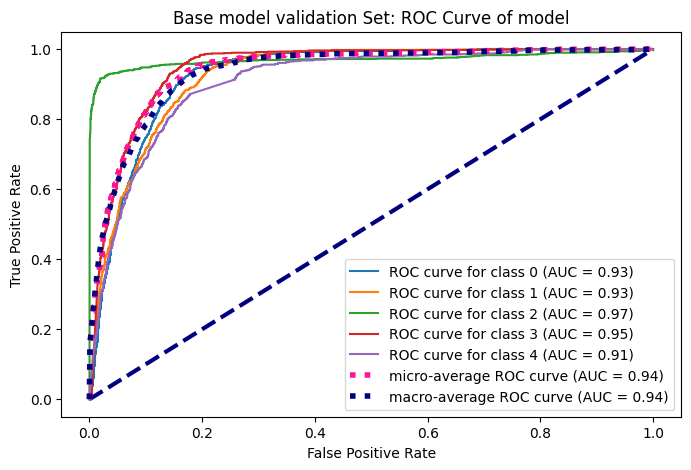

157/157 [==============================] - 1s 7ms/step


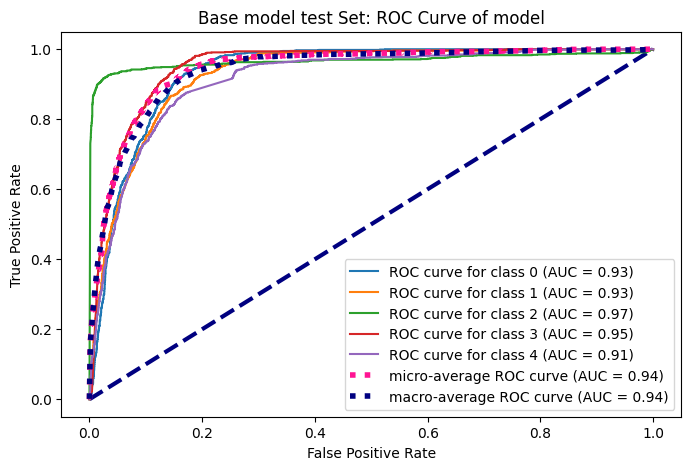

In [ ]:
#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')
#Creating a classification and confusion matrix for the validation data
cm_cl(base, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(base,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(base, X_val, y_val, "Base model validation", n_classes= 5)
ROC_curves(base, X_test, y_test, "Base model test", n_classes= 5)

In [ ]:
print(base.evaluate(X_test,y_test))

import pickle
# Save the model
base.save("/content/drive/MyDrive/base.h5")
# Save the history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
from tensorflow.keras.saving import load_model
base = load_model("/content/drive/MyDrive/base.h5")
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Enhanced Models

# Model: More filters


In [ ]:
#initialize model
model=Sequential()
kernel=(3,3)
#add layers to model
model.add(Conv2D(128,input_shape=(120,120,3),kernel_size=(5,5),activation='relu',padding='same'))  #5x5 kernel for first layer
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=kernel,activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=kernel,activation='relu',padding='same'))#additional convolutional layer
model.add(MaxPooling2D(pool_size=(2,2)))                  #additional max pooling layer
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0

Epoch 1/10
469/469 [==============================] - 29s 40ms/step - loss: 1.7822 - accuracy: 0.4933 - val_loss: 0.8570 - val_accuracy: 0.5796
Epoch 2/10
469/469 [==============================] - 17s 36ms/step - loss: 0.7583 - accuracy: 0.6565 - val_loss: 0.5515 - val_accuracy: 0.7822
Epoch 3/10
469/469 [==============================] - 18s 39ms/step - loss: 0.5737 - accuracy: 0.7537 - val_loss: 0.4749 - val_accuracy: 0.7984
Epoch 4/10
469/469 [==============================] - 18s 38ms/step - loss: 0.4523 - accuracy: 0.7991 - val_loss: 0.3506 - val_accuracy: 0.8668
Epoch 5/10
469/469 [==============================] - 16s 34ms/step - loss: 0.3509 - accuracy: 0.8551 - val_loss: 0.3629 - val_accuracy: 0.8452
Epoch 6/10
469/469 [==============================] - 17s 35ms/step - loss: 0.2991 - accuracy: 0.8797 - val_loss: 0.2857 - val_accuracy: 0.8778
Epoch 7/10
469/469 [==============================] - 18s 38ms/step - loss: 0.2633 - accuracy: 0.8931 - val_loss: 0.2797 - val_accuracy:

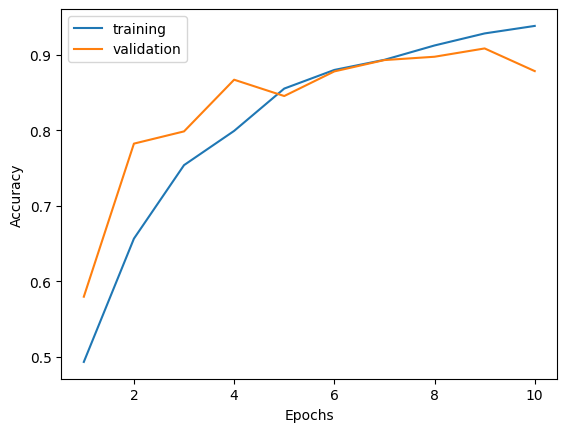

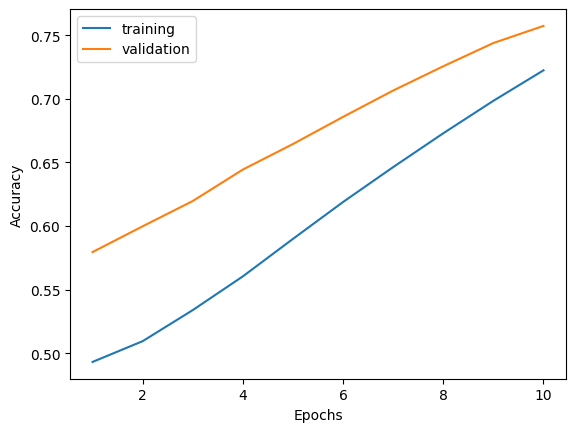

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=10, batch_size=32)
#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')


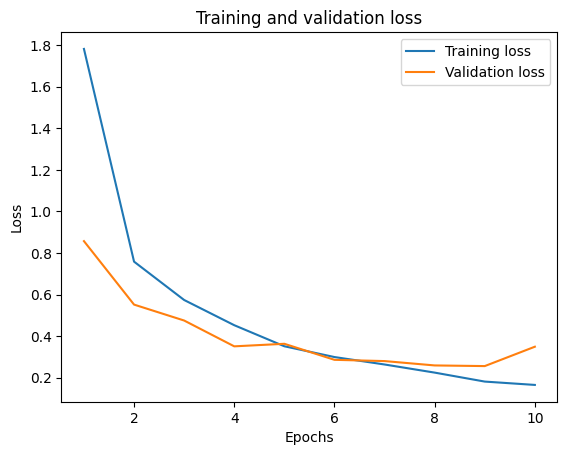

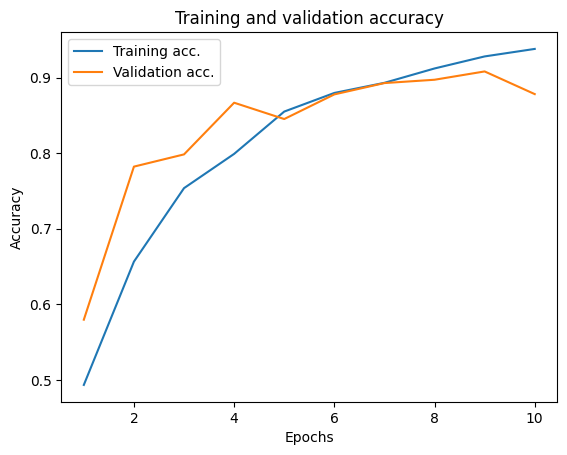

157/157 [==============================] - 1s 8ms/step
test_accuracy: 0.878
[[848 152   0   0   0]
 [ 86 883   1  23   7]
 [ 37   9 939   0  15]
 [  0   0   0 976  24]
 [  1  10   2 242 745]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.84      0.88      0.86      1000
           2       1.00      0.94      0.97      1000
           3       0.79      0.98      0.87      1000
           4       0.94      0.74      0.83      1000

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000

157/157 [==============================] - 1s 7ms/step
test_accuracy: 0.868
[[829 170   0   0   1]
 [ 89 887   2  15   7]
 [ 24  19 939   0  18]
 [  0   0   0 971  29]
 [  0  11   3 272 714]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1000
           1      

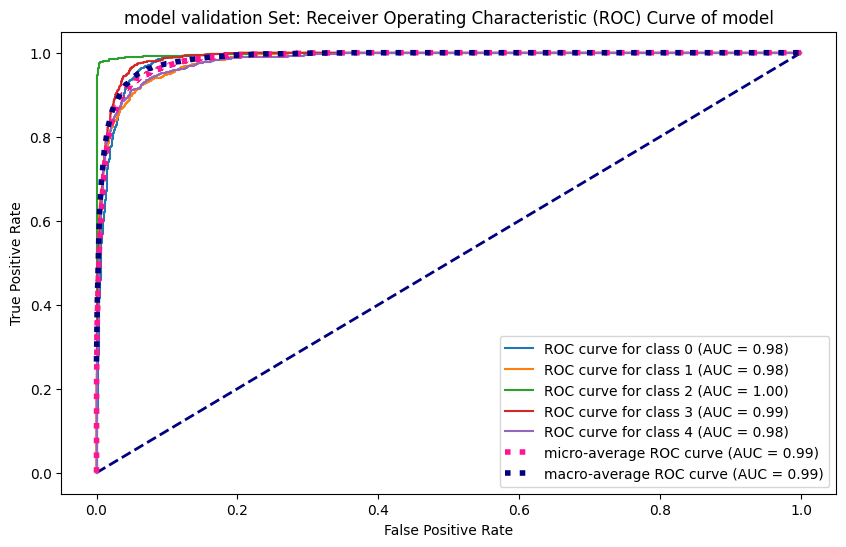

157/157 [==============================] - 1s 8ms/step


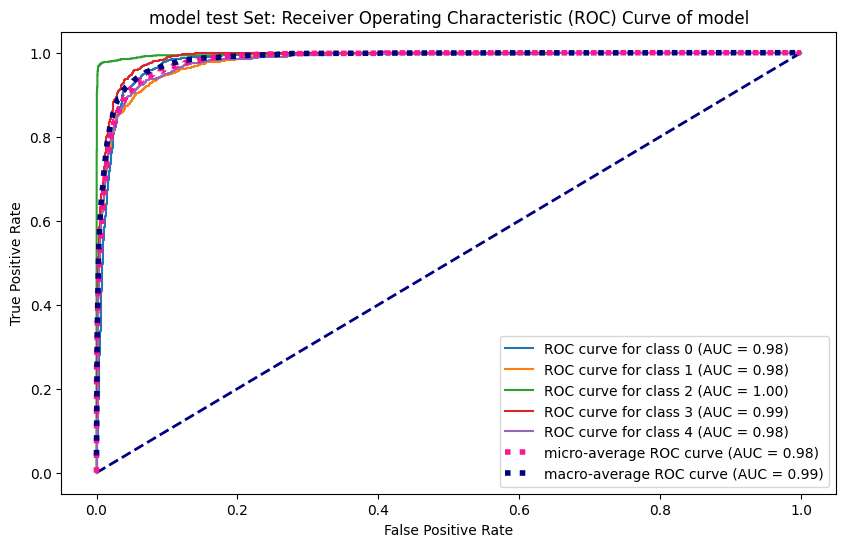

In [ ]:
#Creating a classification and confusion matrix for the validation data
cm_cl(model, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(model,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(model, X_val, y_val, "model validation")
ROC_curves(model, X_test, y_test, "model test")

# Model2: Double the epochs to 20

In [ ]:
#initialize model
model2=Sequential()
kernel=(3,3)
#adding layers to model
model2.add(Conv2D(128,input_shape=(120,120,3),kernel_size=(5,5),activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(64,kernel_size=kernel,activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(32,kernel_size=kernel,activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(Dense(32,activation='relu'))
model2.add(Dense(5,activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 120, 120, 128)     9728      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 15, 15, 32)       

Epoch 1/20
469/469 [==============================] - 18s 35ms/step - loss: 2.5569 - accuracy: 0.5531 - val_loss: 0.6981 - val_accuracy: 0.6824
Epoch 2/20
469/469 [==============================] - 16s 35ms/step - loss: 0.6468 - accuracy: 0.7104 - val_loss: 0.7187 - val_accuracy: 0.6828
Epoch 3/20
469/469 [==============================] - 16s 35ms/step - loss: 0.4803 - accuracy: 0.7945 - val_loss: 0.4284 - val_accuracy: 0.7818
Epoch 4/20
469/469 [==============================] - 15s 32ms/step - loss: 0.3724 - accuracy: 0.8475 - val_loss: 0.2856 - val_accuracy: 0.8864
Epoch 5/20
469/469 [==============================] - 15s 33ms/step - loss: 0.3119 - accuracy: 0.8794 - val_loss: 0.3157 - val_accuracy: 0.8744
Epoch 6/20
469/469 [==============================] - 15s 33ms/step - loss: 0.2733 - accuracy: 0.8935 - val_loss: 0.2991 - val_accuracy: 0.8828
Epoch 7/20
469/469 [==============================] - 15s 33ms/step - loss: 0.2286 - accuracy: 0.9104 - val_loss: 0.2473 - val_accuracy:

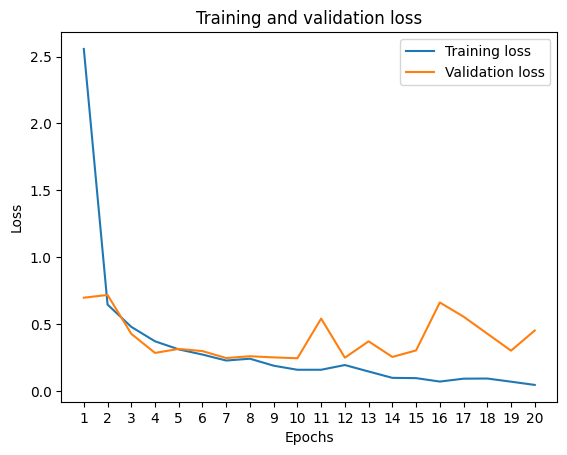

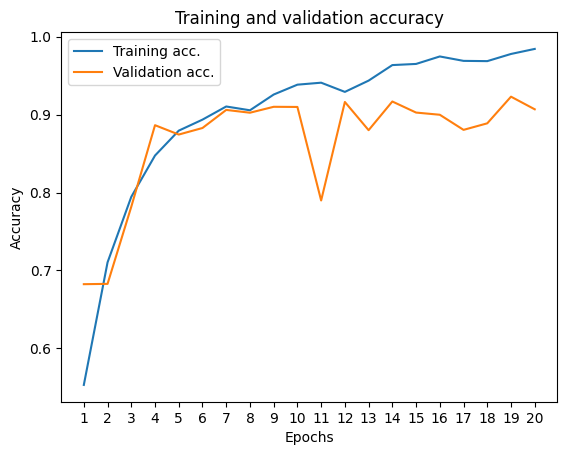

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model2.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=20, batch_size=32)#More epochs

#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

157/157 [==============================] - 1s 9ms/step
test_accuracy: 0.907
Validation data CM
[[923  68   6   0   3]
 [ 90 875   5  22   8]
 [  3   0 980   1  16]
 [  0   0   0 982  18]
 [  1   5   3 217 774]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1000
           1       0.92      0.88      0.90      1000
           2       0.99      0.98      0.98      1000
           3       0.80      0.98      0.88      1000
           4       0.95      0.77      0.85      1000

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

-------------------------------------------------------------------
157/157 [==============================] - 1s 8ms/step
test_accuracy: 0.900
Test data CM
[[912  73  13   0   2]
 [ 98 874   4  16   8]
 [  0   1 982   0  17]
 [  0   0   0 972  28]
 [  1   5   4 232 758]]
              precision    

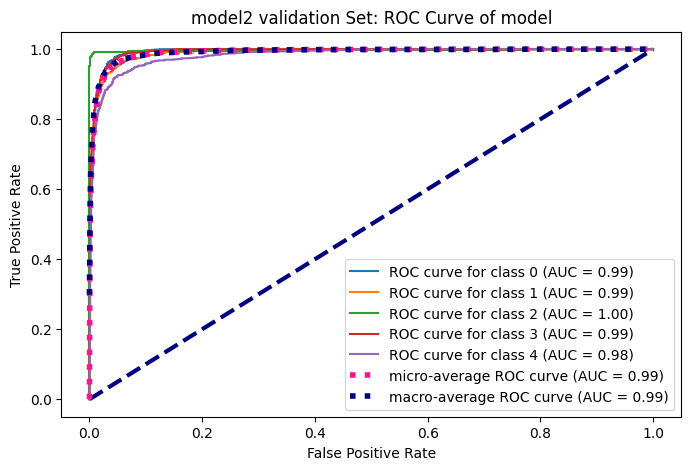

157/157 [==============================] - 1s 8ms/step


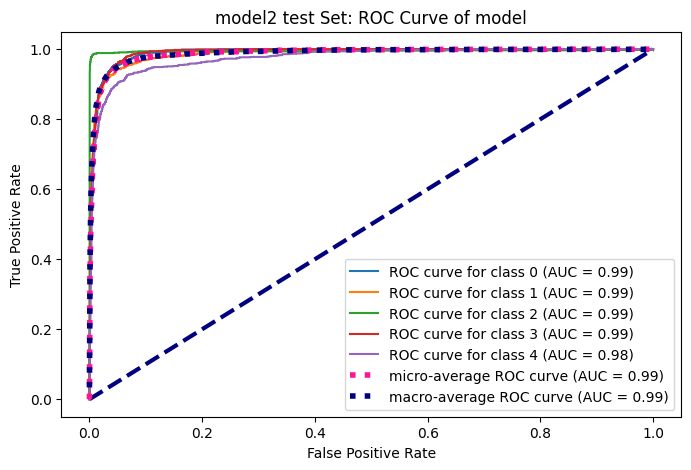

In [ ]:
#Creating a classification and confusion matrix for the validation data
cm_cl(model2, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(model2,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(model2, X_val, y_val, "model2 validation")
ROC_curves(model2, X_test, y_test, "model2 test")

# Model3: Adding dropout

In [ ]:
#initialize model
model3=Sequential()
kernel=(3,3)
#Adding layers to model
model3.add(Conv2D(128,input_shape=(120,120,3),kernel_size=(5,5),activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(64,kernel_size=kernel,activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(32,kernel_size=kernel,activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(128,activation='relu'))    #each cell has a 25% chance to be inactivated for an epoch
model3.add(Dropout(0.25))                   #adding a Dropout layer
model3.add(Dense(32,activation='relu'))
model3.add(Dense(5,activation='softmax'))
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 120, 120, 128)     9728      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 32)       

Epoch 1/20
469/469 [==============================] - 19s 35ms/step - loss: 1.3573 - accuracy: 0.4372 - val_loss: 1.0842 - val_accuracy: 0.4480
Epoch 2/20
469/469 [==============================] - 15s 33ms/step - loss: 0.8783 - accuracy: 0.5765 - val_loss: 0.9321 - val_accuracy: 0.5326
Epoch 3/20
469/469 [==============================] - 15s 33ms/step - loss: 0.7124 - accuracy: 0.6429 - val_loss: 0.6253 - val_accuracy: 0.6488
Epoch 4/20
469/469 [==============================] - 15s 33ms/step - loss: 0.6250 - accuracy: 0.6911 - val_loss: 0.5484 - val_accuracy: 0.7404
Epoch 5/20
469/469 [==============================] - 17s 35ms/step - loss: 0.5679 - accuracy: 0.7215 - val_loss: 0.4890 - val_accuracy: 0.7586
Epoch 6/20
469/469 [==============================] - 15s 33ms/step - loss: 0.4945 - accuracy: 0.7736 - val_loss: 0.4421 - val_accuracy: 0.8000
Epoch 7/20
469/469 [==============================] - 15s 33ms/step - loss: 0.4640 - accuracy: 0.7919 - val_loss: 0.3504 - val_accuracy:

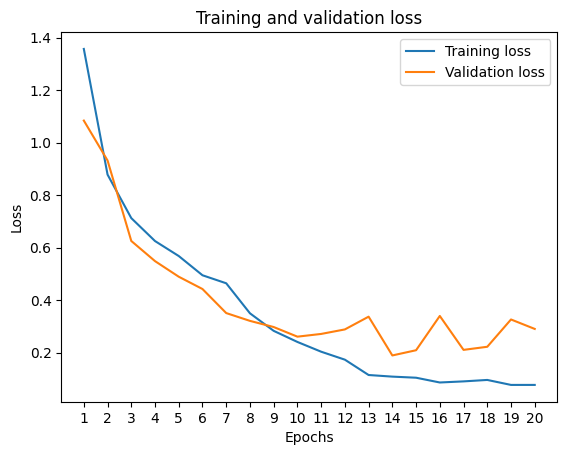

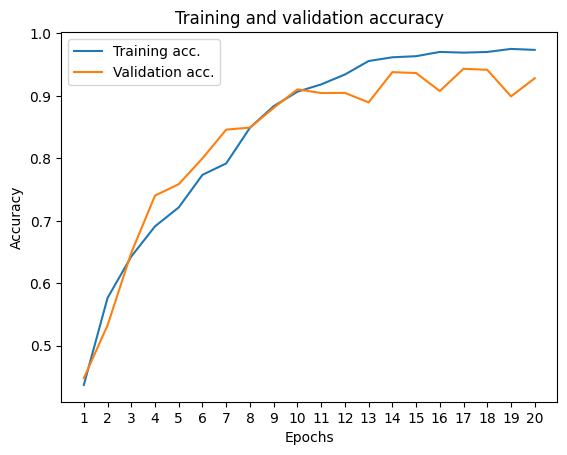

In [ ]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model3.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=20, batch_size=32)

#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

157/157 [==============================] - 1s 9ms/step
test_accuracy: 0.928
Validation data CM
[[963  34   3   0   0]
 [ 43 943   0   2  12]
 [  1   2 985   0  12]
 [  0   0   0 793 207]
 [  0   4   4  35 957]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.96      0.94      0.95      1000
           2       0.99      0.98      0.99      1000
           3       0.96      0.79      0.87      1000
           4       0.81      0.96      0.87      1000

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000

-------------------------------------------------------------------
157/157 [==============================] - 1s 8ms/step
test_accuracy: 0.926
Test data CM
[[980  17   3   0   0]
 [ 46 937   0   2  15]
 [  1   5 972   0  22]
 [  0   0   0 783 217]
 [  0   7   5  29 959]]
              precision    

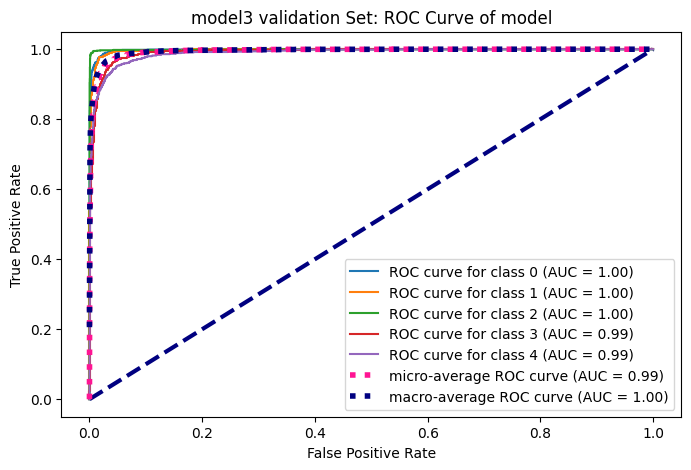

157/157 [==============================] - 1s 8ms/step


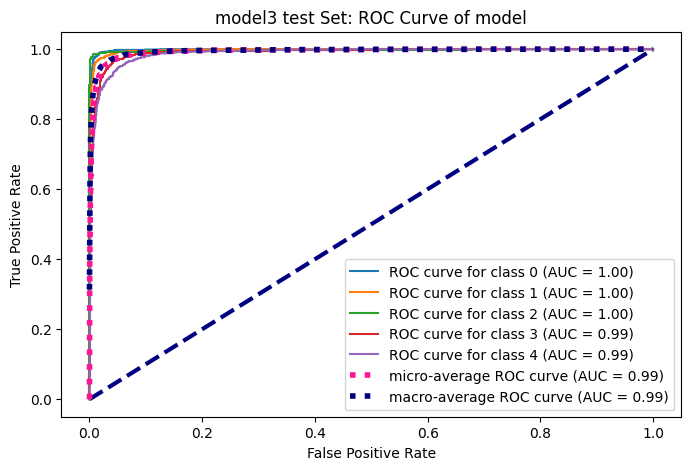

In [ ]:
#Adding the dropout layer together with 20 epochs improved accuracy
#Review of Image Classification Algorithms Based on Convolutional Neural Networks
#Creating a classification and confusion matrix for the validation data
cm_cl(model3, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(model3,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(model3, X_val, y_val, "model3 validation")
ROC_curves(model3, X_test, y_test, "model3 test")

# Model4: adamax brings 95%


In [ ]:
#initialize model
model4=Sequential()
kernel=(3,3)
#add layers to model
model4.add(Conv2D(128,input_shape=(120,120,3),kernel_size=(5,5),activation='relu',padding='same'))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Conv2D(64,kernel_size=kernel,activation='relu',padding='same'))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Conv2D(32,kernel_size=kernel,activation='relu',padding='same'))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Flatten())
model4.add(Dense(128,activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(32,activation='relu'))
model4.add(Dense(5,activation='softmax'))
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 120, 120, 128)     9728      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 32)       

Epoch 1/20
469/469 [==============================] - 21s 39ms/step - loss: 1.1939 - accuracy: 0.5841 - val_loss: 0.5493 - val_accuracy: 0.7428
Epoch 2/20
469/469 [==============================] - 18s 38ms/step - loss: 0.6506 - accuracy: 0.6973 - val_loss: 0.5103 - val_accuracy: 0.7652
Epoch 3/20
469/469 [==============================] - 16s 35ms/step - loss: 0.5261 - accuracy: 0.7645 - val_loss: 0.4067 - val_accuracy: 0.8240
Epoch 4/20
469/469 [==============================] - 18s 38ms/step - loss: 0.4618 - accuracy: 0.7953 - val_loss: 0.3557 - val_accuracy: 0.8446
Epoch 5/20
469/469 [==============================] - 16s 35ms/step - loss: 0.4251 - accuracy: 0.8169 - val_loss: 0.4748 - val_accuracy: 0.7738
Epoch 6/20
469/469 [==============================] - 16s 35ms/step - loss: 0.3510 - accuracy: 0.8565 - val_loss: 0.3516 - val_accuracy: 0.8464
Epoch 7/20
469/469 [==============================] - 16s 35ms/step - loss: 0.2901 - accuracy: 0.8877 - val_loss: 0.3806 - val_accuracy:

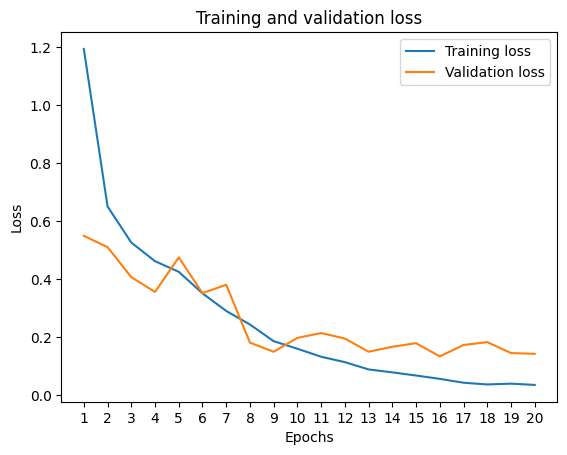

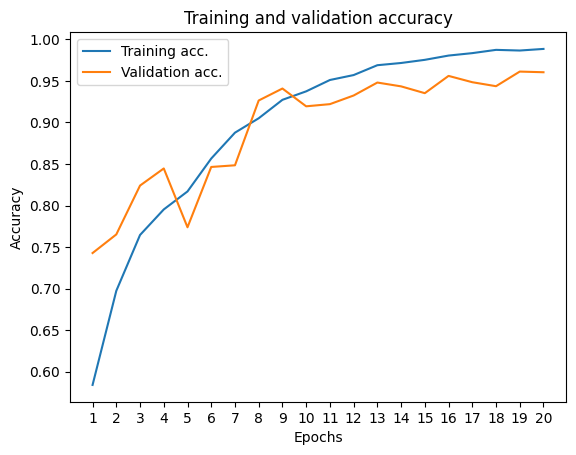

In [ ]:
model4.compile(optimizer="adamax", loss='categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=20, batch_size=32)
#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

157/157 [==============================] - 2s 9ms/step
test_accuracy: 0.960
Validation data CM
[[977  21   2   0   0]
 [ 31 965   2   2   0]
 [  1   1 992   0   6]
 [  0   0   0 949  51]
 [  1   4   9  67 919]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.97      0.96      0.97      1000
           2       0.99      0.99      0.99      1000
           3       0.93      0.95      0.94      1000
           4       0.94      0.92      0.93      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

-------------------------------------------------------------------
157/157 [==============================] - 1s 8ms/step
test_accuracy: 0.964
Test data CM
[[982  16   2   0   0]
 [ 42 953   3   1   1]
 [  1   0 996   0   3]
 [  0   0   0 958  42]
 [  0   6   3  58 933]]
              precision    

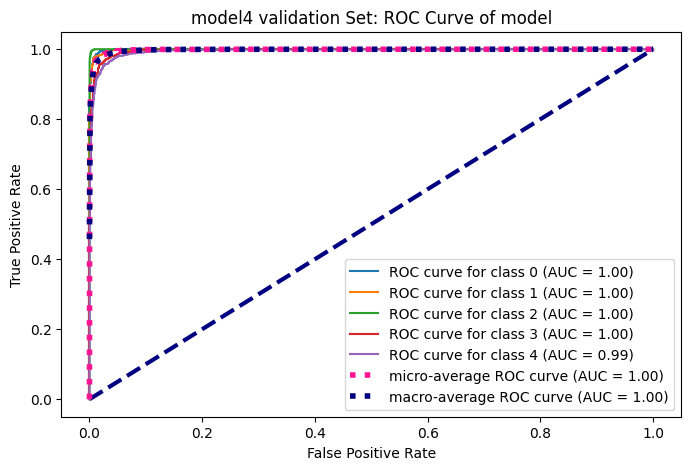

157/157 [==============================] - 1s 8ms/step


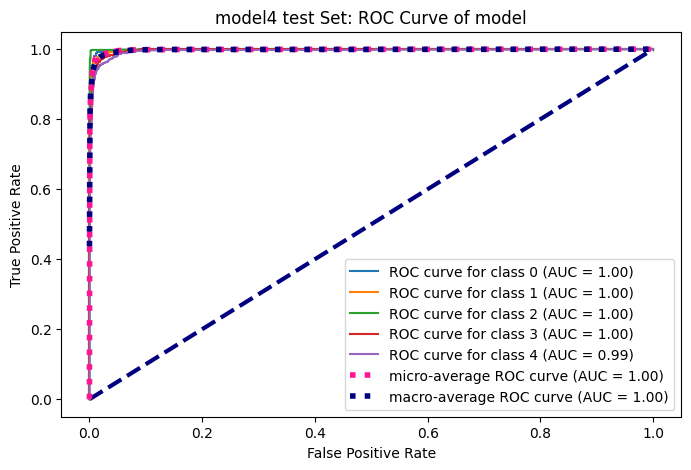

In [ ]:
#Creating a classification and confusion matrix for the validation data
cm_cl(model4, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(model4,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(model4, X_val, y_val, "model4 validation")
ROC_curves(model4, X_test, y_test, "model4 test")
#['Lung adenocarcinoma'] ['Lung Benign Tissue'] ['Lung Squamous Cell Carcinoma'] ['Colon Benign Tissue'] ['Colon adenocarcinoma']
#[0. 0. 0. 0. 1.]         [0. 0. 1. 0. 0.]         [0. 0. 0. 1. 0.]                [1. 0. 0. 0. 0.]            [0. 1. 0. 0. 0.]
























# Model5: Smaller batch size

In [ ]:
#initialize model
model5=Sequential()
kernel=(3,3)
#add layers to model
model5.add(Conv2D(128,input_shape=(120,120,3),kernel_size=(5,5),activation='relu',padding='same'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Conv2D(64,kernel_size=kernel,activation='relu',padding='same'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Conv2D(32,kernel_size=kernel,activation='relu',padding='same'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Flatten())
model5.add(Dense(128,activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(32,activation='relu'))
model5.add(Dense(5,activation='softmax'))
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0

Epoch 1/20
938/938 [==============================] - 25s 20ms/step - loss: 1.1332 - accuracy: 0.5712 - val_loss: 0.5918 - val_accuracy: 0.6926
Epoch 2/20
938/938 [==============================] - 18s 20ms/step - loss: 0.6233 - accuracy: 0.7141 - val_loss: 0.5400 - val_accuracy: 0.7156
Epoch 3/20
938/938 [==============================] - 17s 18ms/step - loss: 0.5146 - accuracy: 0.7726 - val_loss: 0.5092 - val_accuracy: 0.7750
Epoch 4/20
938/938 [==============================] - 17s 18ms/step - loss: 0.4263 - accuracy: 0.8237 - val_loss: 0.3381 - val_accuracy: 0.8560
Epoch 5/20
938/938 [==============================] - 18s 19ms/step - loss: 0.3427 - accuracy: 0.8607 - val_loss: 0.4153 - val_accuracy: 0.8234
Epoch 6/20
938/938 [==============================] - 18s 19ms/step - loss: 0.2712 - accuracy: 0.8934 - val_loss: 0.2445 - val_accuracy: 0.9038
Epoch 7/20
938/938 [==============================] - 19s 20ms/step - loss: 0.2130 - accuracy: 0.9170 - val_loss: 0.2630 - val_accuracy:

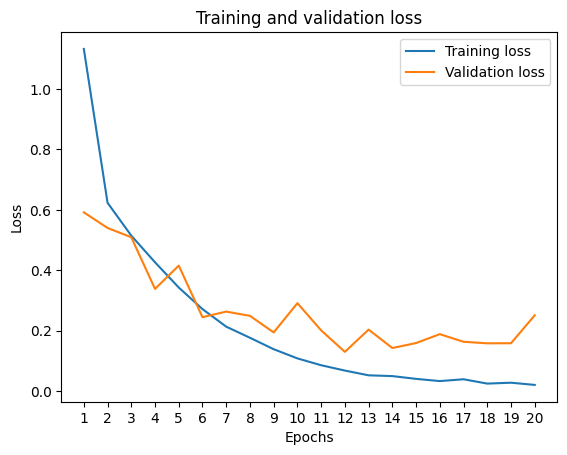

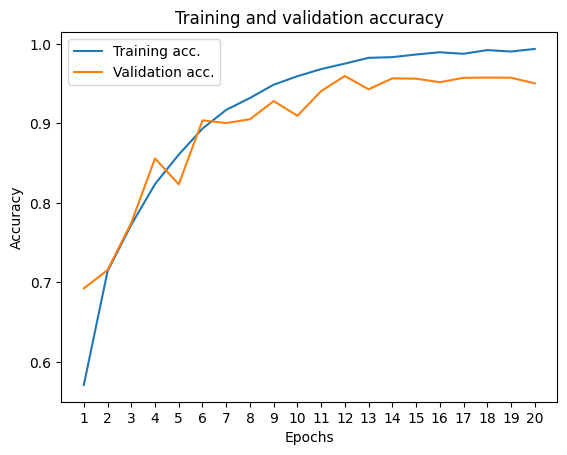

In [ ]:

model5.compile(optimizer="adamax", loss='categorical_crossentropy', metrics=['accuracy'])
history = model5.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=20, batch_size=16) #Decrease batch  size from 32 to 16
#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')


157/157 [==============================] - 2s 8ms/step
test_accuracy: 0.950
Validation data CM
[[949  51   0   0   0]
 [ 23 960   0  12   5]
 [ 10   5 965   0  20]
 [  0   0   0 967  33]
 [  0   4   1  84 911]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1000
           1       0.94      0.96      0.95      1000
           2       1.00      0.96      0.98      1000
           3       0.91      0.97      0.94      1000
           4       0.94      0.91      0.93      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

-------------------------------------------------------------------
157/157 [==============================] - 1s 9ms/step
test_accuracy: 0.951
Test data CM
[[957  42   0   0   1]
 [ 27 967   0   4   2]
 [  9  14 967   0  10]
 [  0   0   0 960  40]
 [  1   3   1  93 902]]
              precision    

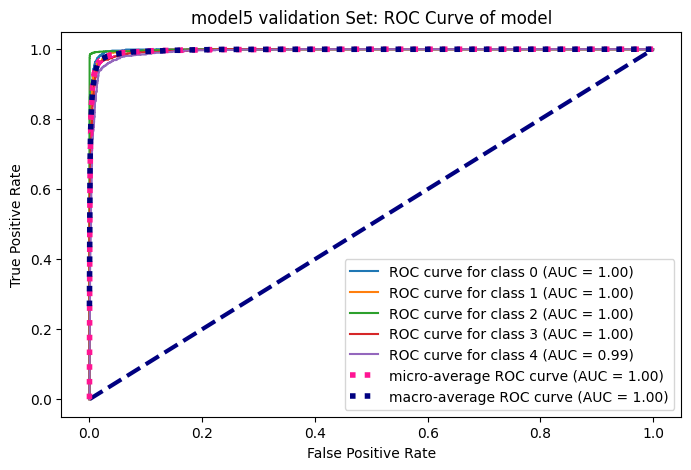

157/157 [==============================] - 1s 8ms/step


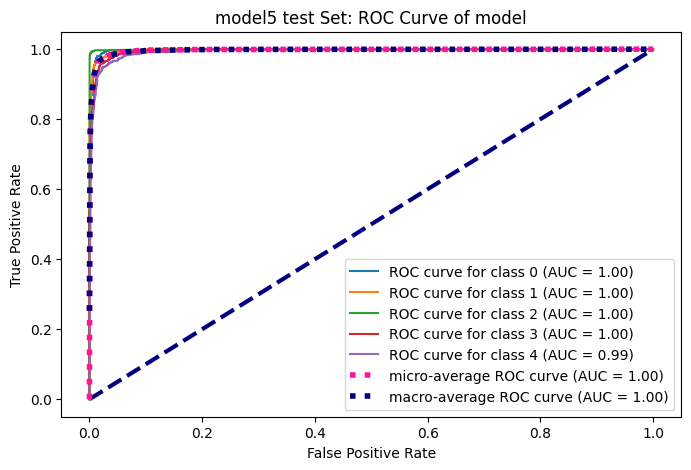

In [ ]:
#Creating a classification and confusion matrix for the validation data
cm_cl(model5, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(model5,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(model5, X_val, y_val, "model5 validation")
ROC_curves(model5, X_test, y_test, "model5 test")
#['Lung adenocarcinoma'] ['Lung Benign Tissue'] ['Lung Squamous Cell Carcinoma'] ['Colon Benign Tissue'] ['Colon adenocarcinoma']
#[0. 0. 0. 0. 1.]         [0. 0. 1. 0. 0.]         [0. 0. 0. 1. 0.]                [1. 0. 0. 0. 0.]            [0. 1. 0. 0. 0.]

# Model6: 4x4 for the first max pooling layer and batch size 32


In [ ]:
#initialize model
model6=Sequential()
kernel=(3,3)
#add layers to model
model6.add(Conv2D(128,input_shape=(120,120,3),kernel_size=(5,5),activation='relu',padding='same'))
model6.add(MaxPooling2D(pool_size=(4,4)))   #doubling pooling size
model6.add(Conv2D(64,kernel_size=kernel,activation='relu',padding='same'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Conv2D(32,kernel_size=kernel,activation='relu',padding='same'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Flatten())
model6.add(Dense(128,activation='relu'))
model6.add(Dropout(0.25))
model6.add(Dense(32,activation='relu'))
model6.add(Dense(5,activation='softmax'))
model6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 120, 120, 128)     9728      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 30, 64)        73792     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 15, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 7, 7, 32)         

Epoch 1/20
469/469 [==============================] - 15s 26ms/step - loss: 1.2839 - accuracy: 0.5829 - val_loss: 0.5360 - val_accuracy: 0.7768
Epoch 2/20
469/469 [==============================] - 11s 24ms/step - loss: 0.5986 - accuracy: 0.7222 - val_loss: 0.4981 - val_accuracy: 0.7546
Epoch 3/20
469/469 [==============================] - 12s 25ms/step - loss: 0.4724 - accuracy: 0.7913 - val_loss: 0.3177 - val_accuracy: 0.8746
Epoch 4/20
469/469 [==============================] - 12s 25ms/step - loss: 0.4043 - accuracy: 0.8301 - val_loss: 0.3457 - val_accuracy: 0.8504
Epoch 5/20
469/469 [==============================] - 11s 24ms/step - loss: 0.3501 - accuracy: 0.8565 - val_loss: 0.2733 - val_accuracy: 0.8782
Epoch 6/20
469/469 [==============================] - 11s 24ms/step - loss: 0.3147 - accuracy: 0.8739 - val_loss: 0.2567 - val_accuracy: 0.8952
Epoch 7/20
469/469 [==============================] - 11s 24ms/step - loss: 0.2854 - accuracy: 0.8869 - val_loss: 0.2007 - val_accuracy:

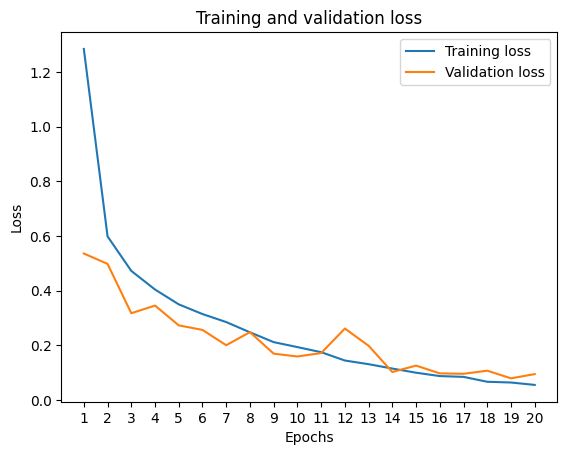

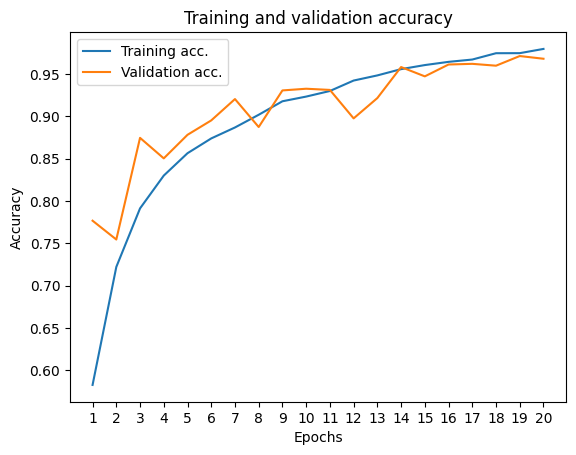

In [ ]:
model6.compile(optimizer="adamax", loss='categorical_crossentropy', metrics=['accuracy'])
history = model6.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=20, batch_size=32)
#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

157/157 [==============================] - 1s 6ms/step
test_accuracy: 0.968
Validation data CM
[[ 985   15    0    0    0]
 [  30  969    1    0    0]
 [   0    0 1000    0    0]
 [   0    0    0  934   66]
 [   2    5    4   37  952]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1000
           1       0.98      0.97      0.97      1000
           2       1.00      1.00      1.00      1000
           3       0.96      0.93      0.95      1000
           4       0.94      0.95      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

-------------------------------------------------------------------
157/157 [==============================] - 1s 6ms/step
test_accuracy: 0.972
Test data CM
[[993   7   0   0   0]
 [ 22 975   3   0   0]
 [  0   0 999   0   1]
 [  0   0   0 940  60]
 [  1   5   6  36 952]]
  

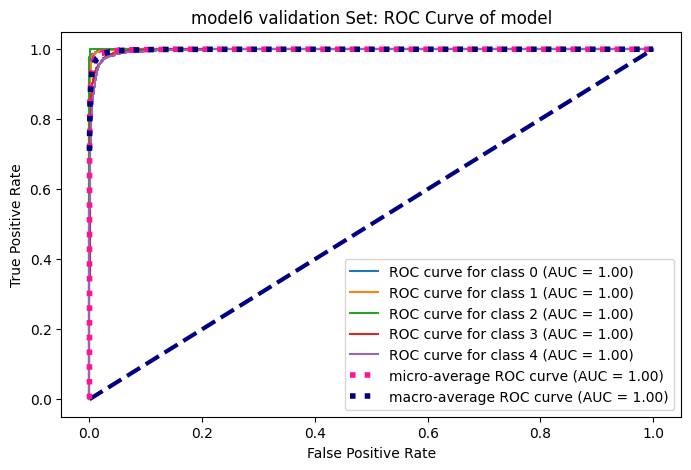

157/157 [==============================] - 1s 5ms/step


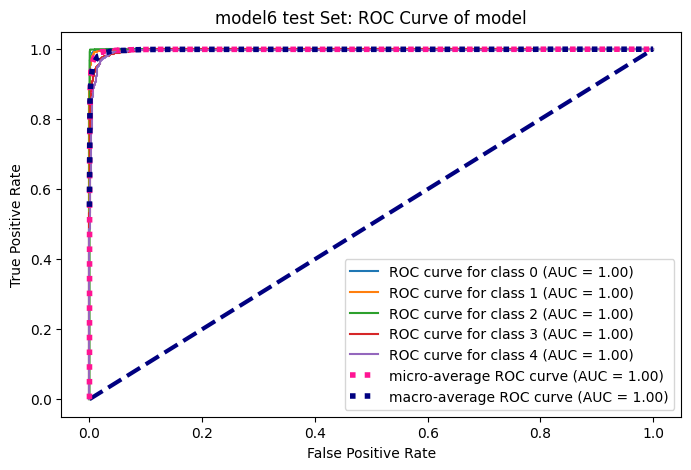

In [ ]:
#Creating a classification and confusion matrix for the validation data
cm_cl(model6, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(model6,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(model6, X_val, y_val, "model6 validation")
ROC_curves(model6, X_test, y_test, "model6 test")
#['Lung adenocarcinoma'] ['Lung Benign Tissue'] ['Lung Squamous Cell Carcinoma'] ['Colon Benign Tissue'] ['Colon adenocarcinoma']
#[0. 0. 0. 0. 1.]         [0. 0. 1. 0. 0.]         [0. 0. 0. 1. 0.]                [1. 0. 0. 0. 0.]            [0. 1. 0. 0. 0.]

# Transfer Learning Model


In [ ]:
#code from the practical
# load model vgg16
vgg_model = VGG16(include_top=False, input_shape=(120, 120, 3))
# summarize the model
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                              

In [ ]:
#code from the practical
# mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False

In [ ]:
#code from the practical
# add new classifier layers
#add flatten layer
flat1 = Flatten()(vgg_model.layers[-1].output)
#add Dense layer
class1 = Dense(128, activation='relu')(flat1)
#add Dropout layer
class2=Dropout(0.25)(class1)
#add Dense layer
class3=Dense(32,activation='relu')(class2)
#add output layer with softmax activation
output = Dense(5, activation='softmax')(class3)
# define new model
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)
# summarize
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

Epoch 1/20
469/469 [==============================] - 33s 61ms/step - loss: 0.6677 - accuracy: 0.8233 - val_loss: 0.2218 - val_accuracy: 0.9238
Epoch 2/20
469/469 [==============================] - 29s 62ms/step - loss: 0.2468 - accuracy: 0.9125 - val_loss: 0.1561 - val_accuracy: 0.9470
Epoch 3/20
469/469 [==============================] - 25s 54ms/step - loss: 0.1690 - accuracy: 0.9385 - val_loss: 0.1512 - val_accuracy: 0.9484
Epoch 4/20
469/469 [==============================] - 25s 54ms/step - loss: 0.1266 - accuracy: 0.9529 - val_loss: 0.1115 - val_accuracy: 0.9620
Epoch 5/20
469/469 [==============================] - 25s 54ms/step - loss: 0.1038 - accuracy: 0.9621 - val_loss: 0.1062 - val_accuracy: 0.9638
Epoch 6/20
469/469 [==============================] - 29s 62ms/step - loss: 0.0780 - accuracy: 0.9711 - val_loss: 0.1052 - val_accuracy: 0.9658
Epoch 7/20
469/469 [==============================] - 29s 63ms/step - loss: 0.0617 - accuracy: 0.9756 - val_loss: 0.1036 - val_accuracy:

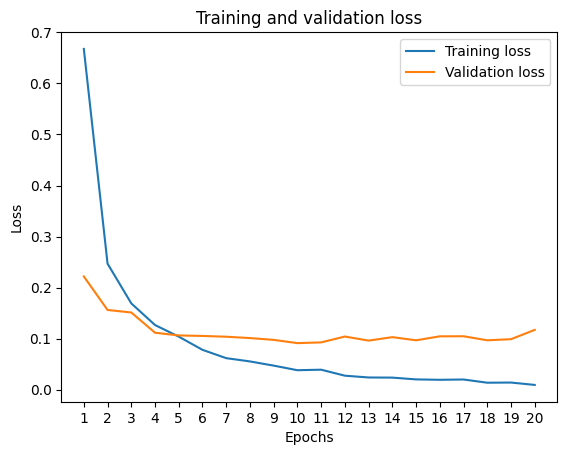

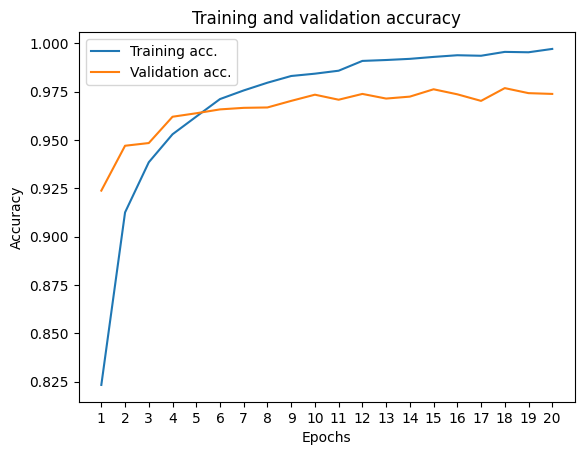

In [ ]:
# compile model
vgg_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
# fit model
history = vgg_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,batch_size=32)
#Initializing accuracy and loss variables for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Plotting the loss of training and validation over the epochs
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
#Plotting the accuracy of training and validation over the epochs
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

157/157 [==============================] - 6s 39ms/step
test_accuracy: 0.978
Validation data CM
[[981  18   0   0   1]
 [  4 984   1   0  11]
 [  0   0 997   0   3]
 [  0   4   0 962  34]
 [  0   6   2  28 964]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       0.97      0.98      0.98      1000
           2       1.00      1.00      1.00      1000
           3       0.97      0.96      0.97      1000
           4       0.95      0.96      0.96      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

-------------------------------------------------------------------
157/157 [==============================] - 6s 40ms/step
test_accuracy: 0.974
Test data CM
[[983  13   1   0   3]
 [  2 983   0   2  13]
 [  0   0 992   0   8]
 [  0   2   0 965  33]
 [  0   4   7  43 946]]
              precision  

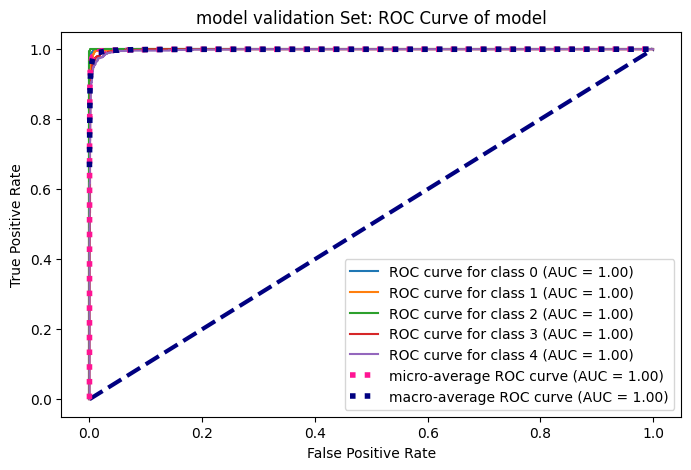

157/157 [==============================] - 6s 40ms/step


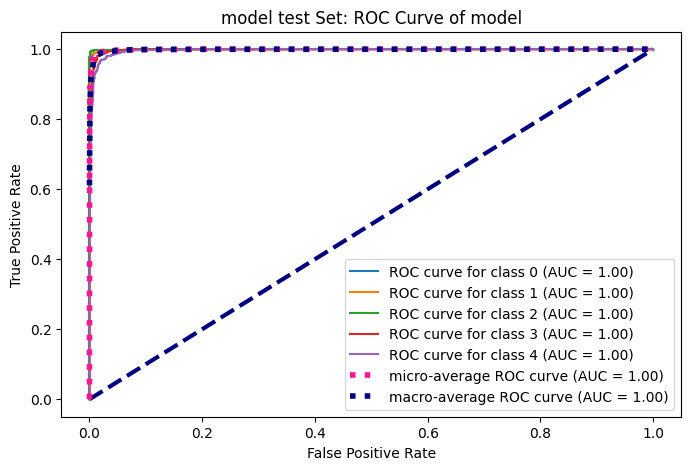

In [ ]:
#Creating a classification and confusion matrix for the validation data
cm_cl(vgg_model, X_val,y_val,"Validation data CM")
#Creating a classification and confusion matrix for the test data
cm_cl(vgg_model,X_test,y_test)
#Plotting ROC with AUC for validation and test set
ROC_curves(vgg_model, X_val, y_val, "model validation")
ROC_curves(vgg_model, X_test, y_test, "model test")